<a href="https://colab.research.google.com/github/emmanuelbillions88/Text-Clustering-Pub/blob/main/IlB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement a Topic Clustering model using LangGraph with nodes for Data Cleaning (spaCy), Vector Extraction (bge-large-en-v1.5), Dimensionality Reduction (UMAP), Clustering (HDBSACN & K-Means), Cluster Naming (Gemini 1.5 Flash and KeyBERT), and Storage (ChromaDB).
The model should use HDBSACN if the numberof clusters is specified and use K-Means for clustering when the number of clusters is specified. The cluster names should be a maximum of 5 words. Include comments in the code.

## Set up the langgraph environment

### Subtask:
Install necessary libraries and define the graph structure with nodes for each stage (Data Cleaning, Vector Extraction, Dimensionality Reduction, Clustering, Cluster Naming, Storage, Visualization) and an orchestrator.


**Reasoning**:
The first step is to enter in the sample_data and install the necessary libraries for the topic clustering model. This involves installing spaCy for data cleaning, sentence-transformers for embedding, umap-learn for dimensionality reduction, scikit-learn and hdbscan for clustering, keybert for cluster naming, and chromadb for storage, along with langgraph for building the graph.



In [ ]:
# Sample data for testing
sample_data = [
"Joe biden rules out 2020 bid: 'guys, i'm not running'",
"Watch: darvish gave hitter whiplash with slow pitch",
"What do you call a turtle without its shell? dead.",
"5 reasons the 2016 election feels so personal",
"Pasco police shot mexican migrant from behind, new autopsy shows",
"Martha stewart tweets hideous food photo, twitter responds accordingly",
"What is a pokemon master's favorite kind of pasta? wartortellini!",
"Why do native americans hate it when it rains in april? because it brings mayflowers.",
"Obama's climate change legacy is impressive, imperfect and vulnerable",
"My family tree is a cactus, we're all pricks.",
"Donald trump has found something mysterious for rudy giuliani to do",
"How donald trump and ted cruz's love affair is all relationships",
"Want to know why athletes chose to #takeaknee? look at our broken justice system",
"How are music and candy similar? we throw away the rappers.",
"Famous couples who help each other stay healthy and fit",
"Study finds strong link between zika and guillain-barre syndrome",
"Alec baldwin and wife hilaria welcome another baby boy",
"Trump says iran is complying with nuclear deal, but remains a dangerous threat",
"Kim kardashian baby name: reality star discusses the 'k' name possibility (video)",
"I just ended a 5 year relationship i'm fine, it wasn't my relationship",
"Here's what the oscar nominations should look like",
"Dating tip: surprise your date! show up a day early.",
"Reflections from davos: leaders deliberate what's next for climate action after paris deal",
"What do you call an explanation of an asian cooking show? a wok-through.",
"Swimming toward a brighter future: how i was introduced to the world of autism",
"Why did little miss muffet have gps on her tuffet? to keep her from losing her whey.",
"The pixelated 'simpsons' should be a real couch gag",
"All pants are breakaway pants if you're angry enough",
"Watch: former british open champ makes embarrassing putting fail",
"Chrissy teigen's 2015 grammy dress is skintight and perfect"
"Ugh, I just spilled red wine all over the inside of my tummy.",
"The next iPhone update will help you save lives.",
"Celebrating the fourth of July with airport profiling.",
"The Big Bend, a U-shaped skyscraper, could become the longest in the world.",
"Oscars 2016 red carpet: all the stunning looks from the Academy Awards.",
"Why do Jews have big noses? Because the air is free.",
"Interesting fact: by the year 2020 all actors on American TV shows will be Australian.",
"I'd tell you a chemistry joke but I know I won't get a reaction.",
"Arkansas approves law to let people carry guns in bars and at public colleges.",
"On set with Paul Mitchell: from our network.",
"Did you know diarrhea is genetic? It runs in your jeans.",
"My son's Ebola joke: What do Africans have for breakfast? Ebola cereal :) (Be kind, he's only 14 lol).",
"What was the sci-fi remake of A Streetcar Named Desire? Interstelllllllaaaaaaar.",
"What do you call a clan of barbarians you can't see? Invisigoths.",
"How do you know if someone is using recursion?",
"Why shouldn't you change around a Pokémon? Because he might peek at chu.",
"Stolen moment of the week: Andy Ofiesh and Kaytlin Bailey at The Creek and The Cave.",
"Obama welcomes Pope Francis to the White House.",
"What do chicken families do on Saturday afternoon? They go on peck-nics!",
"Hiring a cleaning company: A how-to for everyone who wants to go green.",
"Explore America’s stunning marine sanctuaries without getting wet.",
"Do you show up in life in all your amazing glory?",
"What do JCPenney and teenagers have in common? Pants 50% off.",
"Has a conversation in my head - cackles with mirth.",
"Valentine's dinner stress: 4 things not to worry about.",
"Broadway stars join forces to fight North Carolina's anti-LGBT law.",
"I'm really sick of making my dog a birthday cake every 52 days.",
"Knock knock. Who's there? Cotton! Cotton who? Cotton a trap!",
"Safer driving at the flick of a switch.",
"Trump refuses to blame himself for GOP 'not getting the job done'.",
"What do you call a black guy who's hitch-hiking? Stranded!",
"LeBron James doesn't totally deny the possibility of starring in 'Space Jam 2'.",
"Why do they say all minorities look the same? Because once you've seen Juan, you've seen Jamaul.",
"Eve Ensler wants to topple the patriarchy with 'revolutionary love'.",
"Yo momma so ugly ... her portraits hang themselves.",
"Kanye West is opening 21 Pablo pop-up shops this weekend.",
"How to turn leftover champagne into fancy vinegar.",
"Mesmerizing time-lapse video shows dad making amazing Disney bedroom.",
"Wife: You forgot to run the dishwasher again, didn't you? Me: No, why?",
"Resume design: Eye-tracking study finds job seekers have six seconds to make an impression (video).",
"My friend is dealing with a really severe Viagra addiction. He's having a hard time with it.",
"Phil Collins cancels comeback shows after being rushed to hospital.",
"I nicknamed my girlfriend Melody because it's loudest and always on top.",
"121 members of Congress call for end of restrictions on gun violence research.",
"How's my life? Let's just say I'm starting a lot of sentences with 'Let's just say.'",
"Be who you are, no matter what anyone else thinks.",
"Just imagine how good prescription cheese would be.",
"Crazy ex-girlfriends are like a box of chocolates — they will kill your dog.",
"The deeper reason Trump's taco tweet is offensive.",
"Britney Spears is just a regular mom who loves embarrassing her kids.",
"Did you hear about the flying German pancakes in WWII? They were in the Luftwaffle!",
"Kellyanne Conway is wearing a $3,600 coat studded with (ahem) cats.",
"Steelers coach incensed by headset situation at Gillette Stadium.",
"The flame of beauty: Reflections on a poet's journey.",
"If there's two things I've learned in life it's that I'm awful at counting.",
"Canadian army training is 6 weeks of learning how to throw a snowball.",
"What's black and always in the back of a police car? The seat.",
"Ole Miss removes Mississippi flag with Confederate emblem.",
"Cake fix: What to do when it sticks to the pan.",
"Melania Trump's Davos cancellation a 'subliminal message' to Donald: Historian.",
"Why does the ocean have water? Because the sky is *blue*.",
"Carol Field, grandmother, pleads guilty to setting 18 fires across Maine.",
"9 news reporters having laughing fits on live TV (video).",
"Katy Perry wears American flag outfit for kids' inaugural concert (photos).",
"I get sad around the holidays because they always remind me of how much weight I'll be gaining.",
"Starting a cover band called 'A Book' so no one can judge us.",
"Veterinarian accused of shooting neighbors' dog in the head.",
"Christina aguilera's alleged new house comes with famous neighbors (photos)",
"I met a horse who keeps talking about the apocalypse. he told me the end is neigh.",
"As a student the most comforting words you'll ever hear are  i haven't started either",
"The killer cookie-selling tactics of history's most brilliant girl scouts",
"If you watch cinderella backwards its about a woman getting put in her place.",
"If you love something set it free,unless it's a lion. don't do that.",
"Here's how unfair the tax system is in each state",
"Why i un-installed league of legends. to pass my exams, what did you expect?",
]
print("sample_data entered successfully!")

sample_data entered successfully!


In [ ]:
%pip install spacy sentence-transformers umap-learn scikit-learn hdbscan keybert chromadb langgraph --quiet
%pip install langgraph --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 69.5 MB/s eta 0:0

**Reasoning**:
Now that the necessary libraries are installed, I need to import the models from the libaries so they can be used in my LangGraph Structure

In [ ]:
# Import models from LIbaries
from langgraph.graph import StateGraph, END
import typing
from typing import List, Optional, Dict, Any
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
import umap
from sklearn.cluster import KMeans # Keep KMeans for optional use
import hdbscan # Import HDBSCAN
from keybert import KeyBERT
from collections import defaultdict
import google.generativeai as genai
from google.colab import userdata
import chromadb
import matplotlib.pyplot as plt
import seaborn as sns
print("Models imported successfully!")

Models imported successfully!


**Reasoning**:
Now that the necessary libraries are imported, I need to define the state of the graph, instantiate the StateGraph, define the nodes representing each stage of the pipeline.

In [ ]:
# After defining GraphState in the previous cell
class GraphState(typing.TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        input_data: Original input data (list of strings).
        cleaned_data: Data after cleaning (list of strings).
        embeddings: Embeddings of the cleaned data (numpy array).
        reduced_embeddings: Dimensionality-reduced embeddings (numpy array).
        cluster_labels: Labels assigned to each data point (list of ints).
        cluster_names: Names generated for each cluster (dictionary).
        num_clusters: Optional number of clusters for K-Means (int).
        storage_status: Indicates if storage is complete (string).
        visualization_status: Indicates if visualization is complete (string).
        error: Any error encountered during the process (string).
        next_node: Explicitly set next node for orchestrator routing (string).
    """
    input_data: List[str]
    cleaned_data: Optional[List[str]]
    embeddings: Optional[np.ndarray]
    reduced_embeddings: Optional[np.ndarray] # Corrected type hint
    cluster_labels: Optional[List[int]]
    cluster_names: Optional[Dict[int, str]]
    storage_status: Optional[str]
    visualization_status: Optional[str]
    num_clusters: Optional[int]
    error: Optional[str]
    next_node: Optional[str]

print("LangGraph Attributes Defined Successfully")

LangGraph Attributes Defined Successfully


**Reasoning**:
Defining the Data Cleaning Node function

Import spaCy model for text cleaning and processing (Lowercasing, Punctuation and Stop Word reomval)



In [ ]:
# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model 'en_core_web_sm'...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Define the Data Cleaning Node function
def clean_data(state: GraphState) -> Dict[str, List[str]]:
    """
    Cleans the input text data using spaCy.

    This function performs tokenization, lowercasing, removes punctuation and stop words,
    and lemmatizes the tokens to produce cleaned text.

    Args:
        state: The current state of the graph with input_data.

    Returns:
        A dictionary updating the state with cleaned_data.
        Returns an error in the state if input_data is missing.
    """
    print("---DATA CLEANING NODE---")
    input_data = state.get("input_data") # Use .get() for safer access


    if input_data is None:
        print("Error: No input data available for cleaning.")
        return {"error": "No input data available for cleaning."}

    cleaned_texts = []

    for text in input_data:
        if isinstance(text, str): # Ensure the input is a string
             # Process text with spaCy
            doc = nlp(text)

            # Tokenization, lowercasing, punctuation removal, stop word removal, and lemmatization
            cleaned_text = " ".join([
                token.lemma_.lower() for token in doc
                if not token.is_punct and not token.is_stop and not token.is_space
            ])
            cleaned_texts.append(cleaned_text)
        else:
            print(f"Warning: Skipping non-string input: {text}")


    print(f"Cleaned {len(cleaned_texts)} texts.")
    print(f"First cleaned text sample: {cleaned_texts[:1]}") # Debugging print
    print(f"Returning state update: {{'cleaned_data': ...}}") # Debugging print

    return {"cleaned_data": cleaned_texts}

print("Data Cleaning Node implemented and added to the workflow.")

Data Cleaning Node implemented and added to the workflow.


**Reasoning**:
Defining the Vector Extraction Node function

Importing bge-large-en-v1.5 model for extracting vector embeddings

In [ ]:
# Load a pre-trained sentence transformer model for generating embeddings
# Replacing 'intfloat/es-large-v2' with 'bge-large-en-v1.5' as requested
try:
    embedding_model = SentenceTransformer('BAAI/bge-large-en-v1.5')
    print("Loaded embedding model: BAAI/bge-large-en-v1.5")
    print("Vector Extraction Node implemented and added to the workflow.")
except Exception as e:
    print(f"Error loading embedding model 'BAAI/bge-large-en-v1.5': {e}")
    # Handle this error appropriately, maybe return an error state
    raise e # Re-raise the exception if the model fails to load


# Define the Vector Extraction Node function
def extract_embeddings(state: GraphState) -> Dict[str, np.ndarray]:
    """
    Extracts vector embeddings from cleaned text data using the selected pre-trained model.

    This function uses the loaded SentenceTransformer model to encode the cleaned text
    into numerical vector representations.

    Args:
        state: The current state of the graph with cleaned_data.

    Returns:
        A dictionary updating the state with embeddings (numpy array).
        Returns an error in the state if cleaned_data is missing.
    """
    print("---VECTOR EXTRACTION NODE (Updated)---")
    cleaned_data = state.get("cleaned_data") # Use .get() for safer access

    if cleaned_data is None:
        print("Error: No cleaned data available for embedding.")
        return {"error": "No cleaned data available for embedding."}

    print(f"Extracting embeddings for {len(cleaned_data)} lines of texts using the updated model...")
    # Generate embeddings using the new model
    embeddings = embedding_model.encode(cleaned_data)
    print("Embeddings extraction complete (Updated).")
    return {"embeddings": embeddings} # Ensure this returns a dictionary to update state

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Loaded embedding model: BAAI/bge-large-en-v1.5
Vector Extraction Node implemented and added to the workflow.


**Reasoning**:
Defining the Dimensionality Reduction Node function

Importing UMAP for reducing the dimensionality of the vector embeddings

In [ ]:
# Define the Dimensionality Reduction Node function
def reduce_dimensionality(state: GraphState) -> Dict[str, np.ndarray]:
    """
    Reduces the dimensionality of vector embeddings using UMAP.

    This step is crucial for visualizing high-dimensional embeddings and can
    also improve the performance of clustering algorithms by removing noise
    and highlighting meaningful structures. The target dimensionality is
    determined based on the number of input samples.

    Args:
        state: The current state of the graph with embeddings.

    Returns:
        A dictionary updating the state with reduced_embeddings (numpy array).
        Returns an error in the state if embeddings or input_data are missing.
    """
    print("---DIMENSIONALITY REDUCTION NODE---")
    embeddings = state.get("embeddings") # Use .get() for safer access
    input_data = state.get("input_data") # Use .get() for safer access

    if embeddings is None:
        print("Error: No embeddings available for dimensionality reduction.")
        return {"error": "No embeddings available for dimensionality reduction."}

    if input_data is None:
        print("Error: Input data is missing, cannot determine dimensionality.")
        return {"error": "Input data is missing, cannot determine dimensionality."}

    n_samples = len(input_data)
    # Determine target dimensionality based on the number of samples
    if n_samples <= 500:
        n_components = 20
    elif n_samples <= 5000:
        n_components = 30
    elif n_samples <= 20000:
        n_components = 50
    else:
        n_components = 100

    print(f"Reducing dimensionality to {n_components} using UMAP...")
    # Initialize and fit UMAP
    # Using default parameters for simplicity, but these can be tuned
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    print("Dimensionality reduction complete.")
    return {"reduced_embeddings": reduced_embeddings}

print("Dimensionality Reduction Node implemented and added to the workflow.")

Dimensionality Reduction Node implemented and added to the workflow.


**Reasoning**:
Defining the Data Clustering Node function

Import HDBSCAN & K-Means for Clustering so we can use HDBSCAN if no_cluster == None and use K-Means if no_cluster == int()

In [ ]:
# Define the Clustering Node function
def cluster_data(state: GraphState) -> Dict[str, Any]:
    """
    Clusters the dimensionality-reduced data using HDBSCAN or K-Means.

    If `num_clusters` is specified (any integer), K-Means is used for clustering.
    If `num_clusters` is None, HDBSCAN is used.

    Args:
        state: The current state of the graph with reduced_embeddings and optional num_clusters.

    Returns:
        A dictionary updating the state with cluster_labels (list of ints) or an error message.
    """
    print("---CLUSTERING NODE---")
    reduced_embeddings = state.get("reduced_embeddings") # Use .get() for safer access
    num_clusters = state.get("num_clusters")

    if reduced_embeddings is None:
        print("Error: No reduced embeddings available for clustering.")
        return {"error": "No reduced embeddings available for clustering."}

    cluster_labels = None

    # Use K-Means if num_clusters is specified (any integer)
    if num_clusters is not None and isinstance(num_clusters, int) and num_clusters > 0:
        print(f"Applying K-Means to achieve {num_clusters} clusters...")
        try:
            kmeans_model = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans_model.fit_predict(reduced_embeddings)
            print("K-Means clustering complete.")
        except Exception as e:
            print(f"Error during K-Means clustering: {e}")
            return {"error": f"K-Means clustering failed: {e}"}

    # Use HDBSCAN if num_clusters is None
    elif num_clusters is None:
        print("Performing clustering using HDBSCAN...")
        # Use HDBSCAN to find clusters and identify noise points
        # Adjust min_cluster_size and min_samples as needed for your data
        hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5) # Default parameters
        cluster_labels = hdbscan_model.fit_predict(reduced_embeddings)
        n_noise = list(cluster_labels).count(-1)
        print(f"HDBSCAN found {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)} clusters and {n_noise} noise points.")
        print("HDBSCAN clustering complete.")

    else:
        print(f"Invalid value for num_clusters: {num_clusters}. Please provide an integer > 0 for K-Means or None for HDBSCAN.")
        return {"error": f"Invalid value for num_clusters: {num_clusters}"}


    if cluster_labels is not None:
        return {"cluster_labels": cluster_labels.tolist()} # Ensure labels are a list for JSON compatibility
    else:
        return {"error": "Clustering failed to produce labels."}


print("Clustering Node implemented and added to the workflow.")

Clustering Node implemented and added to the workflow.


**Reasoning**:
Defining the Cluster Naming Node function

Importing Gemini 1.5 Flash‑Lite and KeyBERT for assigning semantic names to clusters with a maximum of 5 words. Gemini 1.5 Flash‑Lite is the main model for naming clusters while KeyBERT is a fallback model if Gemini 1.5 Flash‑Lite fails

In [ ]:
# Load a pre-trained KeyBERT model (still useful for keyword suggestions if needed)
kw_model = KeyBERT()

# Configure Gemini API for cluster naming
try:
    # Assuming GOOGLE_API_KEY is already set in the environment or Colab secrets
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    gemini_model = genai.GenerativeModel('gemini-1.5-flash-latest') # Using a suitable model for naming
    print("Gemini API configured successfully.")
    print("Clustering Naming Successful")
except Exception as e:
    print(f"Error configuring Gemini API: {e}")
    gemini_model = None # Set to None if configuration fails


# Define the Cluster Naming Node function
def name_clusters(state: GraphState) -> Dict[str, Dict[int, str]]:
    """
    Names the clusters using Gemini API or KeyBERT, after re-clustering within each initial cluster.

    This function first groups documents by their initial cluster labels. For each cluster,
    it performs K-Means re-clustering with 5 random centroids. It then uses the documents
    within these re-clustered groups to generate a concise, semantic name for the
    *original* cluster using either the Gemini API (if configured) or KeyBERT. It handles
    potential API failures by falling back to KeyBERT and ensures names are a maximum of 5 words.

    Args:
        state: The current state of the graph with input_data and cluster_labels.

    Returns:
        A dictionary updating the state with cluster_names (dictionary mapping original cluster ID to name).
        Returns an error in the state if input_data or cluster_labels are missing.
    """
    print("---CLUSTER NAMING NODE (Refined with Re-clustering)---")
    input_data = state.get("input_data") # Use .get() for safer access
    cluster_labels = state.get("cluster_labels") # Use .get() for safer access
    reduced_embeddings = state.get("reduced_embeddings") # Need embeddings for re-clustering

    if input_data is None or cluster_labels is None or reduced_embeddings is None:
        print("Error: Input data, cluster labels, or reduced embeddings are missing for naming.")
        return {"error": "Input data, cluster labels, or reduced embeddings are missing for naming."}

    # Group documents and their embeddings by initial cluster label
    clustered_data = defaultdict(lambda: {"docs": [], "embeddings": []})
    for doc, label, embedding in zip(input_data, cluster_labels, reduced_embeddings):
        clustered_data[label]["docs"].append(doc)
        clustered_data[label]["embeddings"].append(embedding)

    cluster_names = {}
    # Generate a name for each initial cluster
    for cluster_id, data in clustered_data.items():
        docs = data["docs"]
        embeddings = np.array(data["embeddings"])

        if cluster_id == -1:
            cluster_names[cluster_id] = "Noise"
            continue

        if not docs:
            cluster_names[cluster_id] = "Empty Cluster"
            continue

        cluster_name = None # Initialize cluster_name to None

        # Perform K-Means re-clustering within the current cluster
        n_sub_clusters = min(5, len(docs)) # Re-cluster into at most 5 sub-clusters
        if n_sub_clusters > 1:
            print(f"Re-clustering within original Cluster {cluster_id} using K-Means ({n_sub_clusters} sub-clusters)...")
            try:
                kmeans_sub_model = KMeans(n_clusters=n_sub_clusters, random_state=42, n_init=10)
                sub_cluster_labels = kmeans_sub_model.fit_predict(embeddings)

                # Group documents by sub-cluster
                sub_clustered_docs = defaultdict(list)
                for doc, sub_label in zip(docs, sub_cluster_labels):
                    sub_clustered_docs[sub_label].append(doc)

                # Select a representative document sample from each sub-cluster for naming
                naming_docs = []
                for sub_label, sub_docs in sub_clustered_docs.items():
                    if sub_docs:
                         # Take a sample from each sub-cluster
                        sample_size_per_sub = max(1, len(sub_docs) // n_sub_clusters) # Adjust sample size based on sub-cluster size
                        naming_docs.extend(np.random.choice(sub_docs, size=min(sample_size_per_sub, len(sub_docs)), replace=False).tolist())

                # Limit the total number of documents for naming to avoid exceeding context window
                naming_docs = naming_docs[:20] # Still limit the total documents for the prompt

            except Exception as e:
                print(f"Error during K-Means re-clustering for Cluster {cluster_id}: {e}. Using original documents for naming.")
                naming_docs = docs[:20] # Fallback to using original docs sample

        else:
             # If only one document or sub-cluster not possible, use original docs sample
             naming_docs = docs[:20]

        # Use Gemini API for naming if configured
        if gemini_model and naming_docs:
            print(f"Attempting to generate name for original Cluster {cluster_id} using Gemini API based on re-clustered samples...")
            # Refine the prompt to be more direct about the desired output format and constraints
            prompt = f"""Analyze the following sample texts from a cluster and provide a concise name (maximum 5 words) that summarizes the main topic. Ensure the name is semantic and easy to understand.

Texts:
{'- '.join(naming_docs)}

Concise Name (max 5 words):"""
            try:
                response = gemini_model.generate_content(prompt)
                if response and response.text:
                    cluster_name_raw = response.text.strip()
                    # Ensure the concise name is max 5 words
                    cluster_name = " ".join(cluster_name_raw.split()[:5])
                    print(f"Generated name for original Cluster {cluster_id} with Gemini API: {cluster_name}")
                else:
                    print(f"Gemini API returned an empty response for original Cluster {cluster_id}. Falling back to KeyBERT.")
            except Exception as e:
                print(f"Error generating name for original Cluster {cluster_id} with Gemini API: {e}. Falling back to KeyBERT.")

        # Fallback to KeyBERT if Gemini API failed or not configured, or if no naming docs
        if cluster_name is None and (docs and naming_docs):
            print(f"Using KeyBERT for original Cluster {cluster_id}...")
            # Use a representative set of documents for KeyBERT
            keybert_docs = naming_docs if naming_docs else docs[:50] # Use naming docs if available, otherwise a larger sample from original
            cluster_text = " ".join(keybert_docs)
            keywords = kw_model.extract_keywords(
                cluster_text,
                keyphrase_ngram_range=(1, 3),
                stop_words='english',
                use_mmr=True,
                diversity=0.7,
                top_n=5
            )
            keyword_list = [keyword[0] for keyword in keywords]
            # Combine keywords into a name, ensuring it's max 5 words
            cluster_name = " ".join(keyword_list).split()[:5]
            cluster_name = " ".join(cluster_name)

            print(f"Generated name for original Cluster {cluster_id} with KeyBERT: {cluster_name}")
        elif cluster_name is None:
             cluster_name = "Unnamed Cluster"
             print(f"Could not generate name for original Cluster {cluster_id} using Gemini or KeyBERT.")


        cluster_names[cluster_id] = cluster_name


    print("Cluster naming complete (Refined with Re-clustering).")
    return {"cluster_names": cluster_names} # Ensure this returns a dictionary to update state

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Gemini API configured successfully.
Clustering Naming Successful


**Reasoning**:
Defining the Storage Node function

Importing ChromaDB for storing clusters

In [ ]:
# Load ChromaDB for storage
client = chromadb.Client()
# Uncomment to disable ChromaDB analytics
# %env CHROMA_ANALYTICS=False

# Define the Storage Node function
def store_results(state: GraphState) -> Dict[str, Any]:
    """
    Stores the clustered data and cluster names in ChromaDB.

    This function creates a collection in ChromaDB and adds the original documents
    along with their assigned cluster labels and names as metadata.

    Args:
        state: The current state of the graph with input_data, cluster_labels, and cluster_names.

    Returns:
        A dictionary indicating the storage is complete or an error message.
        Returns an error in the state if input_data, cluster_labels, or cluster_names are missing.
    """
    print("---STORAGE NODE---")
    input_data = state.get("input_data") # Use .get() for safer access
    cluster_labels = state.get("cluster_labels") # Use .get() for safer access
    cluster_names = state.get("cluster_names") # Use .get() for safer access

    if input_data is None or cluster_labels is None or cluster_names is None:
        print("Error: Data, labels, or names are missing for storage.")
        return {"error": "Data, labels, or names are missing for storage."}

    # Create or get a collection
    collection_name = "topic_clusters"
    try:
        # Attempt to delete collection if it exists to avoid issues with re-adding
        client.delete_collection(name=collection_name)
        print(f"Deleted existing collection: {collection_name}")
    except:
        pass # Ignore if collection doesn't exist

    try:
        collection = client.create_collection(name=collection_name)
        print(f"Created collection: {collection_name}")
    except Exception as e:
        print(f"Error creating collection: {e}")
        return {"error": f"Error creating collection: {e}"}


    # Prepare data for ChromaDB
    ids = [f"doc_{i}" for i in range(len(input_data))]
    # Store original text and cluster label as metadata
    metadatas = []
    for i in range(len(input_data)):
        metadata = {"cluster_label": str(cluster_labels[i])}
        # Add cluster name to metadata if available
        if cluster_labels[i] in cluster_names:
            metadata["cluster_name"] = cluster_names[cluster_labels[i]]
        metadatas.append(metadata)


    # Add data to the collection
    # Note: ChromaDB requires embeddings for add, but we only need to store text and metadata for this task
    # A workaround is to use the original embeddings or generate dummy ones if not available.
    # For simplicity, we will store the original text as documents and metadata.
    # If you need to query by similarity, you would store the embeddings here.
    print(f"Adding {len(input_data)} documents to ChromaDB collection '{collection_name}'...")
    try:
        collection.add(
            documents=input_data,
            metadatas=metadatas,
            ids=ids
        )
        print("Storage complete.")
        return {"storage_status": "complete"}
    except Exception as e:
        print(f"Error adding documents to collection: {e}")
        return {"error": f"Error adding documents to collection: {e}"}

print("Storage Node implemented and added to the workflow.")

Storage Node implemented and added to the workflow.


**Reasoning**:
Defining the Visualization Node function

Importing UMAP reducing dimensionality embeddings for visualization (Scatter plots)

In [ ]:
# Define the Visualization Node function
def visualize_clusters(state: GraphState) -> Dict[str, Any]:
    """
    Visualizes the clustered, dimensionality-reduced data using UMAP and cluster labels/names.

    This function generates a scatter plot of the 2D dimensionality-reduced data,
    coloring points by their cluster labels and adding a legend with cluster names.

    Args:
        state: The current state of the graph with reduced_embeddings, cluster_labels, and cluster_names.

    Returns:
        A dictionary indicating the visualization is complete or an error message.
        Returns an error in the state if reduced_embeddings, cluster_labels, or cluster_names are missing.
    """
    print("---VISUALIZATION NODE---")
    reduced_embeddings = state.get("reduced_embeddings") # Use .get() for safer access
    cluster_labels = state.get("cluster_labels") # Use .get() for safer access
    cluster_names = state.get("cluster_names") # Use .get() for safer access
    input_data = state.get("input_data")

    if reduced_embeddings is None or cluster_labels is None or cluster_names is None:
        print("Error: Reduced embeddings, cluster labels, or cluster names are missing for visualization.")
        return {"error": "Reduced embeddings, cluster labels, or cluster names are missing for visualization."}

    # Ensure reduced_embeddings are in a plottable format (e.g., 2D)
    if reduced_embeddings.shape[1] > 2:
         print("Warning: Reduced embeddings are not 2D. Performing UMAP again for visualization.")
         try:
            # Reduce to 2 components specifically for visualization
            reducer_2d = umap.UMAP(n_components=2, random_state=42)
            reduced_embeddings_2d = reducer_2d.fit_transform(reduced_embeddings)
         except Exception as e:
             print(f"Error reducing dimensionality to 2D for visualization: {e}")
             return {"error": f"Error reducing dimensionality to 2D for visualization: {e}"}
    else:
        reduced_embeddings_2d = reduced_embeddings

    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x=reduced_embeddings_2d[:, 0],
        y=reduced_embeddings_2d[:, 1],
        hue=cluster_labels,
        palette='viridis',
        legend='full',
        alpha=0.7
    )

    # Add cluster names as labels to the plot (optional, can be crowded)
    # You might want to add labels only for cluster centroids or a sample of points
    # For simplicity, let's use a legend with names
    handles, labels = scatter.get_legend_handles_labels()
    # Map numeric labels to cluster names for the legend
    named_labels = [cluster_names.get(int(label), f"Cluster {label}") for label in labels]
    plt.legend(handles, named_labels, title="Clusters")


    plt.title('Cluster Visualization (UMAP)')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

    print("Visualization complete.")
    return {"visualization_status": "complete"}

print("Visualization Node inplemented and added to the workflow")

Visualization Node inplemented and added to the workflow


**Reasoning**:
Define the orchestrator function for controlling the flow based on the presence of the number of clusters parameter, set the entry point to the orchestrator, define the edges between the nodes, and set the end point.


In [ ]:
# Define the Orchestrator Node function
def orchestrator(state: GraphState) -> Dict[str, str]:
    """
    Directs the workflow based on the current state and presence of errors.

    This node acts as the central control, determining the next processing step
    based on which stages have been completed or if an error has occurred.

    Args:
        state: The current state of the graph.

    Returns:
        A dictionary updating the state with the next_node to execute or END.
    """
    print("---ORCHESTRATOR NODE---")
    error = state.get("error")
    storage_status = state.get("storage_status")
    visualization_status = state.get("visualization_status")

    # If there's an error, stop the process
    if error:
        print(f"Error detected: {error}. Stopping workflow.")
        return {"next_node": END, "error": error}

    # Determine next step based on completed steps in sequence
    # Check for the latest completed step first
    if state.get("cleaned_data") is None:
        print("Proceeding to data cleaning.")
        return {"next_node": "clean"}
    elif state.get("embeddings") is None and state.get("cleaned_data") is not None:
        print("Proceeding to vector extraction.")
        return {"next_node": "embed"}
    elif state.get("reduced_embeddings") is None and state.get("embeddings") is not None:
        print("Proceeding to dimensionality reduction.")
        return {"next_node": "reduce_dim"}
    elif state.get("cluster_labels") is None and state.get("reduced_embeddings") is not None:
        print(" Proceeding to clustering.")
        return {"next_node": "cluster"}
    elif state.get("cluster_names") is None and state.get("cluster_labels") is not None:
        print("Proceeding to cluster naming.")
        return {"next_node": "name_clusters"}
    elif state.get("storage_status") is None and state.get("cluster_names") is not None:
         print("Proceeding to storage.")
         return {"next_node": "store"}
    elif visualization_status is None and state.get("cluster_names") is not None:
         print("Proceeding to visualization.")
         return {"next_node": "visualize_clusters"}
    else:
        print("All processing steps complete. Ending workflow.")
        return {"next_node": END}


print("Orchestrator Node inplemented and added to the workflow")

Orchestrator Node inplemented and added to the workflow


**Reasoning**:
This connects the LangGraph workflow together

This is where the MAGIC happen!👇

---ORCHESTRATOR NODE---
Proceeding to data cleaning.
---DATA CLEANING NODE---
Cleaned 104 texts.
First cleaned text sample: ['joe biden rule 2020 bid guy run']
Returning state update: {'cleaned_data': ...}
---ORCHESTRATOR NODE---
Proceeding to vector extraction.
---VECTOR EXTRACTION NODE (Updated)---
Extracting embeddings for 104 lines of texts using the updated model...
Embeddings extraction complete (Updated).
---ORCHESTRATOR NODE---
Proceeding to dimensionality reduction.
---DIMENSIONALITY REDUCTION NODE---
Reducing dimensionality to 20 using UMAP...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionality reduction complete.
---ORCHESTRATOR NODE---
 Proceeding to clustering.
---CLUSTERING NODE---
Performing clustering using HDBSCAN...
HDBSCAN found 4 clusters and 51 noise points.
HDBSCAN clustering complete.
---ORCHESTRATOR NODE---
Proceeding to cluster naming.
---CLUSTER NAMING NODE (Refined with Re-clustering)---
Re-clustering within original Cluster 1 using K-Means (5 sub-clusters)...
Attempting to generate name for original Cluster 1 using Gemini API based on re-clustered samples...
Generated name for original Cluster 1 with Gemini API: US Politics & Elections
Re-clustering within original Cluster 0 using K-Means (5 sub-clusters)...
Attempting to generate name for original Cluster 0 using Gemini API based on re-clustered samples...
Generated name for original Cluster 0 with Gemini API: Celebrity News & Style
Re-clustering within original Cluster 2 using K-Means (5 sub-clusters)...
Attempting to generate name for original Cluster 2 using Gemini API based on re-clustere

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 59.0MiB/s]


Storage complete.
---ORCHESTRATOR NODE---
Proceeding to visualization.
---VISUALIZATION NODE---


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


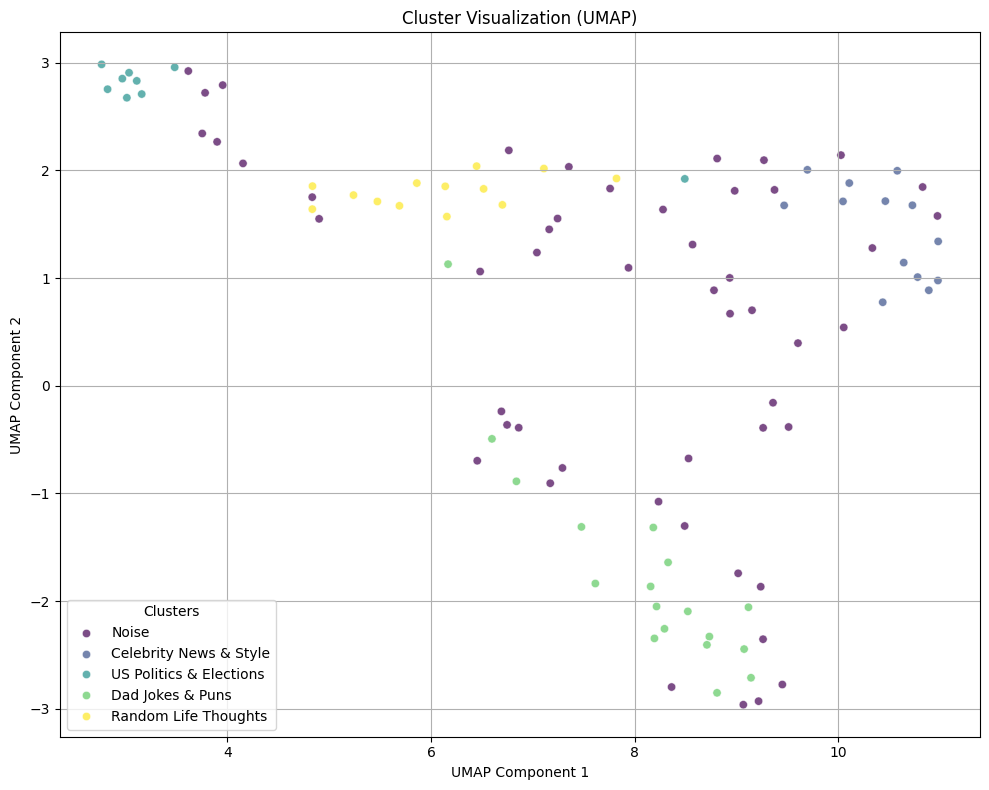

Visualization complete.
---ORCHESTRATOR NODE---
All processing steps complete. Ending workflow.

---Workflow Execution Complete---
Cluster Labels: [1, -1, -1, 1, -1, 0, 2, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 0, 3, 0, 2, -1, 2, 3, 2, 0, 2, -1, 0, 3, -1, -1, 0, 2, -1, -1, -1, -1, 2, 2, -1, -1, 3, 2, -1, -1, 2, -1, 3, 3, -1, 2, -1, -1, 2, 2, -1, 1, -1, -1, 0, -1, -1, -1, 2, 0, 2, -1, -1, -1, -1, -1, 3, 3, 2, -1, 1, 0, -1, 0, -1, 3, 3, -1, -1, -1, 2, 1, 3, -1, -1, 0, -1, -1, -1, 0, 2, -1, -1, 0, 3, 3, -1]
Cluster Names: {1: 'US Politics & Elections', -1: 'Noise', 0: 'Celebrity News & Style', 2: 'Dad Jokes & Puns', 3: 'Random Life Thoughts'}


In [ ]:
# Define the LangGraph workflow
workflow = StateGraph(GraphState)

# Add nodes for each stage of the workflow
workflow.add_node("clean", clean_data) # Node for data cleaning
workflow.add_node("embed", extract_embeddings) # Node for vector embedding extraction
workflow.add_node("reduce_dim", reduce_dimensionality) # Node for dimensionality reduction
workflow.add_node("cluster", cluster_data) # Node for clustering
workflow.add_node("name_clusters", name_clusters) # Node for naming clusters
workflow.add_node("store", store_results) # Node for storing results in ChromaDB
workflow.add_node("visualize_clusters", visualize_clusters) # Node for visualizing clusters
workflow.add_node("orchestrator", orchestrator) # Node for directing the workflow


# Set the entry point of the workflow to the orchestrator
workflow.set_entry_point("orchestrator")

# Add conditional edges from the orchestrator
# The orchestrator's return value (the string name of the next node or END)
# will determine which node to execute next.
workflow.add_conditional_edges(
    "orchestrator",
    lambda state: state.get("next_node", "clean"), # Evaluate the state for the next node name
    {
        "clean": "clean", # If orchestrator returns "clean", go to the clean node
        "embed": "embed", # If orchestrator returns "embed", go to the embed node
        "reduce_dim": "reduce_dim", # If orchestrator returns "reduce_dim", go to the reduce_dim node
        "cluster": "cluster", # If orchestrator returns "cluster", go to the cluster node
        "name_clusters": "name_clusters", # If orchestrator returns "name_clusters", go to the name_clusters node
        "store": "store", # If orchestrator returns "store", go to the store node
        "visualize_clusters": "visualize_clusters", # If orchestrator returns "visualize_clusters", go to the visualize_clusters node
        END: END # If orchestrator returns END, the workflow stops
    }
)

# Define the edges (transitions) between nodes
# Each processing node transitions back to the orchestrator to decide the next step
workflow.add_edge("clean", "orchestrator")
workflow.add_edge("embed", "orchestrator")
workflow.add_edge("reduce_dim", "orchestrator")
workflow.add_edge("cluster", "orchestrator")
workflow.add_edge("name_clusters", "orchestrator")
workflow.add_edge("store", "orchestrator")
workflow.add_edge("visualize_clusters", "orchestrator") # After visualization, go back to orchestrator to potentially end


# Define the final edge from the last processing node to END
# This edge signifies the end of the workflow after visualization is complete.
workflow.add_edge("visualize_clusters", END)


# Compile the workflow into a runnable application
app = workflow.compile()

# Define the initial inputs for the workflow
# 'input_data' contains the text data to be processed.
# 'num_clusters' is an optional parameter for the clustering node.
# Setting 'num_clusters' to an integer will attempt to use K-Means with that number of clusters
# Setting 'num_clusters' to None will use HDBSCAN clustering.
# Setting 'num_clusters' to none will lead to an error. Use 'None' instead


inputs = {"input_data": sample_data, "num_clusters": None}


# Invoke the workflow with the defined inputs and store the final state
final_state = app.invoke(inputs)

print("\n---Workflow Execution Complete---")
# You can further inspect the results from the final state, e.g., the cluster labels and names
print("Cluster Labels:", final_state.get("cluster_labels"))
print("Cluster Names:", final_state.get("cluster_names"))

**Reasoning**:
This Cell shows the stored clusters and their contents

In [ ]:
# Get the cluster labels, cluster names, and original input data from the final state
cluster_labels = final_state.get("cluster_labels")
cluster_names = final_state.get("cluster_names")
input_data = final_state.get("input_data")

if cluster_labels is None or cluster_names is None or input_data is None:
    print("Cluster labels, names, or input data not found in the final state.")
else:
    # Group documents by cluster label
    clustered_docs = defaultdict(list)
    for doc, label in zip(input_data, cluster_labels):
        clustered_docs[label].append(doc)

    # Print the contents of each cluster
    print("\n--- Cluster Contents ---")
    for cluster_id, docs in clustered_docs.items():
        cluster_name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")
        print(f"\nCluster {cluster_id}: {cluster_name} (Count: {len(docs)})")
        for i, doc in enumerate(docs):
            print(f"  {i+1}. {doc}")


--- Cluster Contents ---

Cluster 1: US Politics & Elections (Count: 9)
  1. Joe biden rules out 2020 bid: 'guys, i'm not running'
  2. 5 reasons the 2016 election feels so personal
  3. Donald trump has found something mysterious for rudy giuliani to do
  4. How donald trump and ted cruz's love affair is all relationships
  5. Want to know why athletes chose to #takeaknee? look at our broken justice system
  6. Trump says iran is complying with nuclear deal, but remains a dangerous threat
  7. Trump refuses to blame himself for GOP 'not getting the job done'.
  8. The deeper reason Trump's taco tweet is offensive.
  9. Melania Trump's Davos cancellation a 'subliminal message' to Donald: Historian.

Cluster -1: Noise (Count: 51)
  1. Watch: darvish gave hitter whiplash with slow pitch
  2. What do you call a turtle without its shell? dead.
  3. Pasco police shot mexican migrant from behind, new autopsy shows
  4. Why do native americans hate it when it rains in april? because it bring